# Noise audio preprocessing and training dataset creation

In [1]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt

### Directory structure
Audio file dataset folders are in the subfolder "01_audioDatasets/..." <br>
("01_audioDatasets" folder is excluded from git, the relative path to this folder is in the gitignore file)<br>

In case of new dataset --> new folder in "01_Data/01_audioDatasets/"

```
01_Electrical_Connector_Click-Event_Detection_git_repo/
└─── 01_Data/
    └─── 01_audioDatasets/ (excluded from git)
        ├─── 01_ethernet_without_additional_noise
        ├─── 02_ethernet_with_additional_noise
        ├─── ...
        ├─── 07_noise_samples
        ├─── [New dataset folders go here]
        
    └─── clickDatasetPreprocessing.ipynb (current notebook)
└─── ...
```

In [2]:
# list all audio file datasets in folder "01_Data/01_audioDatasets"

cwd = str(Path.cwd()) # current working directory, should be the path to 01_Dataset, in which this notebook is located
audio_datasets_main_dir_name = "01_audioDatasets"
audio_datasets_main_dir = os.path.join(cwd, audio_datasets_main_dir_name)
audio_datasets = []

if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets) # sort the list of audio datasets
else:
    print("\"01_audioDatasets\" directory does not exist or is not in the correct location.")

print(audio_datasets)

['01_ethernet_without_additional_noise', '02_ethernet_with_additional_noise', '03_kombination_1_without_additional_noise', '04_kombination_1_with_additional_noise', '05_kombination_2_without_additional_noise', '06_kombination_2_with_additional_noise', '07_noise_samples', 'voice_memo_loc_mac.txt']


In [3]:
# select noise dataset

dataset_num = 6 # ID of noise audio dataset
print("Selected dataset: ", audio_datasets[dataset_num])

Selected dataset:  07_noise_samples


In [8]:
# add audio files from selected dataset to a list

audio_dataset_dir = os.path.join(cwd, audio_datasets_main_dir_name) + "/" + audio_datasets[dataset_num]
audio_files = [f for f in os.listdir(audio_dataset_dir) if f.endswith('.m4a')]
audio_files_sorted = sorted(audio_files)
print(f"Dataset length: {len(audio_files_sorted)}")
print("Files in the noise dataset:")
print(audio_files_sorted)

Dataset length: 7
Files in the noise dataset:
['01_screws.m4a', '02_hex_keys.m4a', '03_plastic_part.m4a', '04_screw_drivers.m4a', '05_pliers.m4a', '06_coughing.m4a', '07_reference_silence.m4a']


In [16]:
# functions from the notebook "preprocessing_audio_wo_additional_noise.ipynb"

def next_power_of_2(x):
        next_power_of_two = 2**(math.ceil(math.log(x, 2)))

        if next_power_of_two == x:
            next_power_of_two = next_power_of_two*2

        return next_power_of_two

def power_mel_to_db(D_mel, a_squere_min, dB_ref):

        D_mel_dB = 10.0 * np.log10(np.maximum(a_squere_min, np.minimum(D_mel, dB_ref))/dB_ref)

        return D_mel_dB

def get_mel_spectrogram(audio_file_path, sampling_rate, n_fft, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref):

    D_mel_dB = None
    
    signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)

    n_samples = len(signal) # number of samples in the signal
    duration = n_samples / sampling_rate # duration of the signal in seconds
    time = np.linspace(0, duration, n_samples) # time vector for the plot

    # STFT calculation
    signal_stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, win_length=n_fft)

    # power spectrogram,
    D = np.abs(signal_stft) ** 2  #I = c * A^2, where c is a constant, A is amplitude, I is intensity (Roberts 1984)

    # creating the mel filter bank
    mel_filter_bank = librosa.filters.mel(sr=sampling_rate, n_fft=n_fft, n_mels=n_mels, fmin=f_min, fmax = f_max, htk=True, norm = 1) 
    # if norm = 1 -> filters are normalized to sum to 1
    # if htk = True -> use Mel(f) = 2595 * np.log10(1 + frequency / 700) formula

    # applying the mel filter bank to the power spectrogram
    D_mel = np.dot(mel_filter_bank, D)
    
    if a_squere_min != None and dB_ref != None:

        D_mel_dB = power_mel_to_db(D_mel, a_squere_min=a_squere_min, dB_ref=dB_ref)

    return signal, time, D_mel, D_mel_dB

def plot_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate):

    fig_x = 16
    fig_y = 6
    fig, axs = plt.subplots(2, 1, figsize=(fig_x, fig_y))

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(time, signal)
    ax1.set_xlim(left=0, right=time[-1])
    #ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Amplitude')
    ax1.set_xlim(left=time[0], right=time[-1])

    ax2 = plt.subplot(2, 1, 2)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Frequency [Hz]')
    #ax2.set_yscale('log')
    #ax2.set_xlim(left=time[0], right=time[-1])
    ax2.axes.xaxis.set_ticklabels([]) 
    mel_spec_img = ax2.pcolormesh(np.linspace(0, signal.shape[0] / sampling_rate, D_mel_dB.shape[1]),
                                            np.linspace(f_min, f_max, n_mels), 
                                            D_mel_dB, shading='auto', cmap='inferno')

    #mel_spec_img.set_clim(vmin=-top_dB_abs, vmax=dB_ref)
    mel_spec_img.set_clim(vmin=-top_dB_abs, vmax=0)

    cbar_ax = fig.add_axes([0.15, -0.05, 0.7, 0.02])
    fig.colorbar(mel_spec_img, cax=cbar_ax, orientation='horizontal', format="%+2.0f dB")

    plt.show()


In [15]:
# constant parameters from the notebook "preprocessing_audio_wo_additional_noise.ipynb"

sampling_rate = 32000

chunk_size = 4096 # number of samples in one chunk of audio data
spectrogram_columns_per_chunk = 8 # number of spectrogram columns in one chunk of audio data

resolution = (chunk_size/sampling_rate)/spectrogram_columns_per_chunk # 0.016 seconds when processing a chunk of 4096 samples at a sampling rate of 32 kHz with 8 spectrogram columns per chunk

hop_length = int(resolution * sampling_rate) # the number of samples between successive frames in the STFT
n_fft =  next_power_of_2(hop_length) # length of the windowed signal after padding with zeros in the STFT
n_mels = 128 # number of mel bands (rows in the mel-scaled spectrogram), 128 is a common value

f_min = 20 # minimum frequency in Hz, from the microphone specification
f_max = 14000 # maximum frequency in Hz, the microphone has a max frequency response of 20 kHz, however, the sampling rate is 32 kHz, so the max frequency can be 16 kHz or lower

dB_ref = 1e3 # reference value for dB conversion
a_squere_min = 1e-12 # larger than 0 to avoid log(0)
top_dB_abs = abs(10*np.log10(a_squere_min)) # maximum dB value -> 10*log(a_squere_min) = -120

/var/folders/bj/7ggffpq918g65k1n35l6t6t40000gn/T/ipykernel_6705/1400562503.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


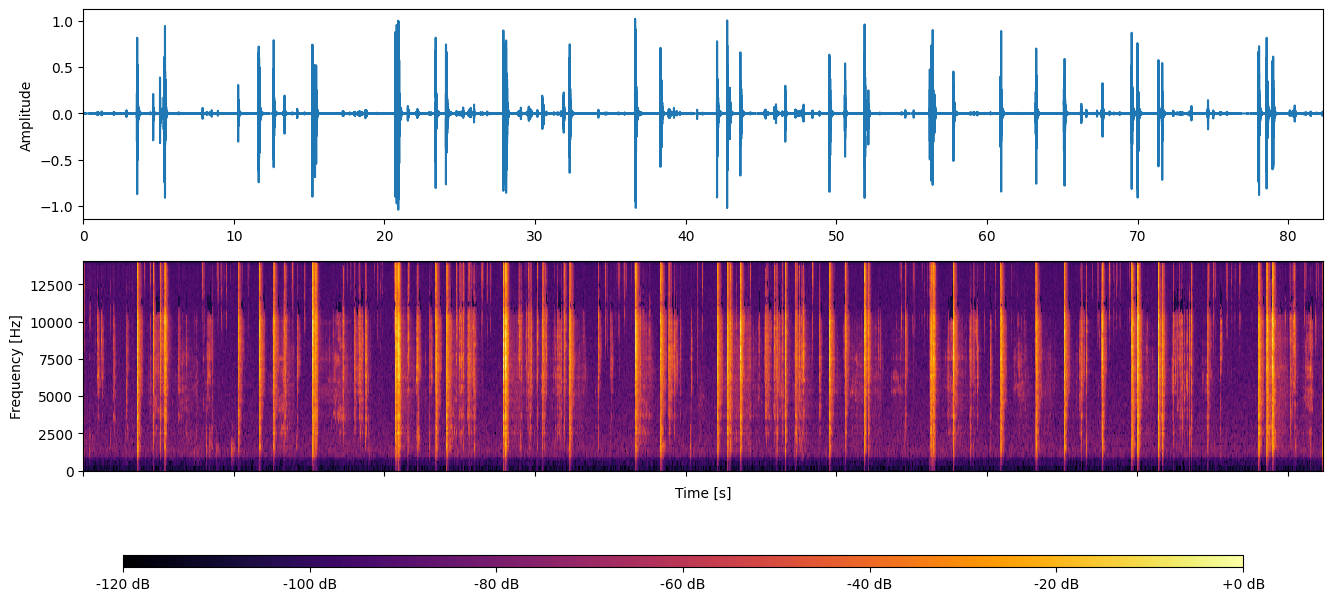

In [23]:
# plot the wave and mel spectrogram of an audio file from the noise dataset

file_id_num = 0 # selected file ID number

if file_id_num < len(audio_files_sorted):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[file_id_num])
    signal, time, D_mel, D_mel_dB = get_mel_spectrogram(audio_file_path, sampling_rate, n_fft, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
    plot_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("File ID out of range")

In [18]:
# splitting all audio files into chunks

time_interval = (chunk_size/sampling_rate) * 4
window_size_sec = time_interval # 0.512 seconds, corresponds to 4 chunks with 4096 samples each, should be larger than the click event duration!!
window_size = int(window_size_sec / resolution) # spectrogram columns in the window
step_size_sec = 0.128 # in seconds, corresponds to a chunks with 4096 samples --> overlap
step_size = int(step_size_sec / resolution)
print(window_size, step_size)

32 8


In [27]:
# calculate the max dB value in the reference silence audio file
file_id_num = 6 # ID of the reference silence audio file
audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[file_id_num])
signal, time, D_mel, D_mel_dB = get_mel_spectrogram(audio_file_path, sampling_rate, n_fft, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)

max_dB = np.max(D_mel_dB)
print(max_dB)

-45.020218


/var/folders/bj/7ggffpq918g65k1n35l6t6t40000gn/T/ipykernel_6705/1400562503.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)


In [32]:
# get audio spectrograms for all audio files in the noise dataset except the reference silence audio file

audio_files_exept_ref = audio_files_sorted.copy()
audio_files_exept_ref.pop(6) # remove the reference silence audio file

spectrograms = []
signals = []
signal_times = []

for audio_file in audio_files_exept_ref:
    audio_file_path = os.path.join(audio_dataset_dir, audio_file)
    signal, time, D_mel, D_mel_dB = get_mel_spectrogram(audio_file_path, sampling_rate, n_fft, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
    spectrograms.append(D_mel_dB)
    signals.append(signal)
    signal_times.append(time)


/var/folders/bj/7ggffpq918g65k1n35l6t6t40000gn/T/ipykernel_6705/1400562503.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [37]:
# create spectrogram chunks and corresponding labels (0) for the selected dataset (excluding the reference silence file)

spec_chunk_dataset = []
spec_chunk_labels = []
signal_chunks = []
time_chunks = []

dB_threshold = max_dB + 20 # threshold for noise chunks

def createSpectrogramDataset(spectrograms, signals, signal_times):
    for i in range(len(spectrograms)):
        spectrogram = spectrograms[i]
        signal = signals[i]
        time = signal_times[i]

        for start_idx in range(0, spectrogram.shape[1] - window_size, step_size):
            end_idx = start_idx + window_size
            
            spectrogram_chunk = spectrogram[:,start_idx:end_idx]
            signal_chunk = signal[start_idx*hop_length:end_idx*hop_length]
            time_chunk = time[start_idx*hop_length : end_idx*hop_length]
            
            label = 0 # no click event

            if np.max(spectrogram_chunk) > dB_threshold:
                spec_chunk_dataset.append(spectrogram_chunk)
                spec_chunk_labels.append(label)
                signal_chunks.append(signal_chunk)
                time_chunks.append(time_chunk)

    return spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks

spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks = createSpectrogramDataset(spectrograms, signals, signal_times)

print(len(spec_chunk_dataset)) # number of spectrogram chunks
print(len(spec_chunk_labels)) # number of labels

1192
1192


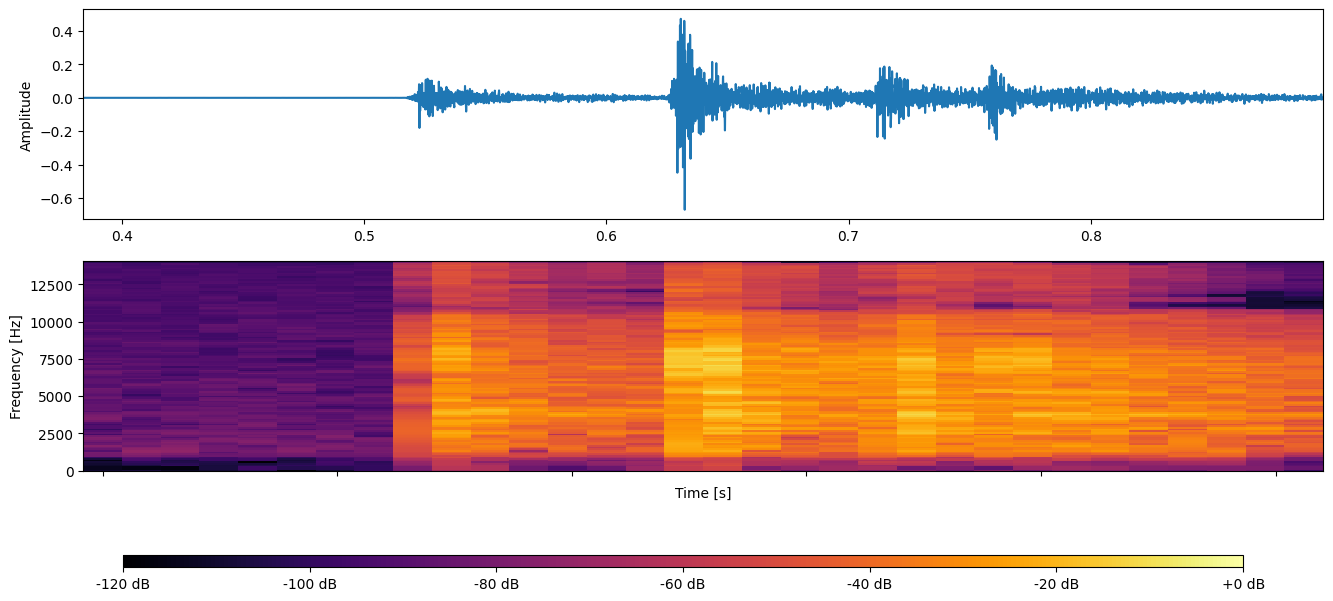

In [52]:
# plot chunk

chunk_id_to_plot = 400

if chunk_id_to_plot < len(spec_chunk_dataset):
    plot_mel_spectrogram(signal_chunks[chunk_id_to_plot], time_chunks[chunk_id_to_plot], spec_chunk_dataset[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("Chunk ID out of range")

In [50]:
# save the noise spectrogram dataset and labels in .npz format into the same directory as the noise audio files

save_directory = audio_dataset_dir
filename = "noise_dataset.npz"
file_fullpath = os.path.join(save_directory, filename)

spec_chunk_dataset = np.array(spec_chunk_dataset)
spec_chunk_labels = np.array(spec_chunk_labels)

#print(np.min(spec_chunk_dataset), np.max(spec_chunk_dataset))

np.savez(file_fullpath, spec_chunks=spec_chunk_dataset, labels=spec_chunk_labels)

(128, 32)
1192
1192
0


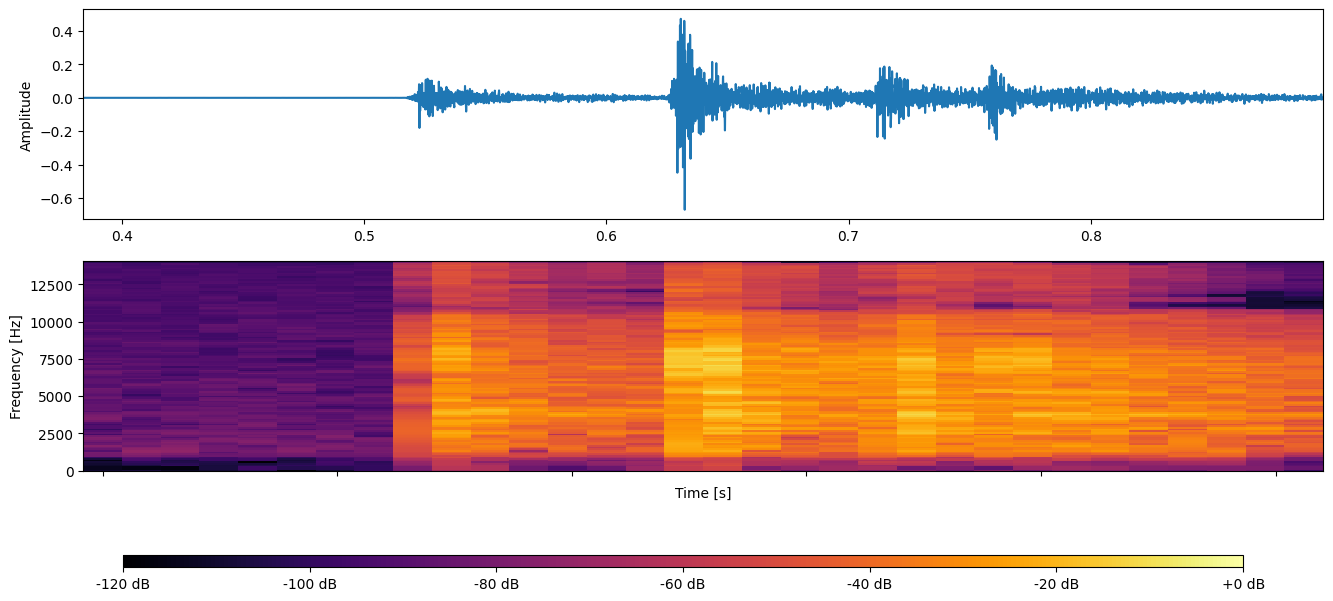

In [53]:
# check if the saved dataset can be loaded

data = np.load(file_fullpath)
loaded_chunks = data['spec_chunks']
loaded_labels = data['labels']

print(loaded_chunks[0].shape)
print(len(loaded_chunks))
print(len(loaded_labels))

# plot out one spectrogram chunk
plot_mel_spectrogram(signal_chunks[chunk_id_to_plot], time_chunks[chunk_id_to_plot], loaded_chunks[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)